# Artificial Intelligence II - HW 1

**Sakarellos Ioannis (sdi1800167)**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def split_data(train, test, test_size=0.15):

  X_train = train[['url', 'review']]
  y_train = train[['rating']]

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, shuffle=True)

  if test != None:
    X_val = test[['url', 'review']]
    y_val = test[['rating']]

  return X_train.reset_index().drop('index', axis=1), X_val.reset_index().drop('index', axis=1), y_train.reset_index().drop('index', axis=1), y_val.reset_index().drop('index', axis=1)

In [ ]:
def process_data(X_data_set, y_data_set, remove_stop_words=False):

  X = X_data_set
  y = y_data_set

  X.drop('url', axis=1, inplace=True)
  X['review'] = X['review'].str.lower()

  X['review'].replace(r'<.*?>', ' ', regex=True, inplace=True)
  X['review'].replace(r'[^\w\s]', ' ', regex=True, inplace=True)
  X['review'].replace(r'\d', ' ', regex=True, inplace=True)
  X['review'].replace(r'\s+', ' ', regex=True, inplace=True)

  if remove_stop_words:
    nltk.download('stopwords')
    STOP_WORDS = stopwords.words('english')

    X['review'] = X['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOP_WORDS)]))

  y['label'] = y.apply(lambda row: 0 if row.rating < 5 else 1, axis=1)
  y.drop('rating', axis=1, inplace=True)

  return X.squeeze(), y.squeeze()

In [ ]:
def plot_curves(sample_size, prec_val, prec_tr, rec_val, rec_tr, f1_val, f1_tr):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

  ax1.plot(sample_size, prec_val)
  ax1.plot(sample_size, prec_tr)
  ax1.set_ylim(bottom=0, top=1)
  ax1.legend(['Validation', 'Training'])
  ax1.set_title('Precision Score')

  ax2.plot(sample_size, rec_val)
  ax2.plot(sample_size, rec_tr)
  ax2.set_ylim(bottom=0)
  ax2.legend(['Validation', 'Training'])
  ax2.set_title('Recall Score')

  ax3.plot(sample_size, f1_val)
  ax3.plot(sample_size, f1_tr)
  ax3.set_ylim(bottom=0)
  ax3.legend(['Validation', 'Training'])
  ax3.set_title('F1 Score')

In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/Artificial Intelligence II/imdb-reviews.csv', sep='\t')
test = None

train.head()

,url,rating,review
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...


In [ ]:
X_train_original, X_val_original, y_train_original, y_val_original = split_data(train, test)

In [ ]:
X_train, y_train = process_data(X_train_original, y_train_original, remove_stop_words=True)
X_val, y_val = process_data(X_val_original, y_val_original, remove_stop_words=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

## Testing Different Models

### Count Vectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
parameters = {'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}

X, _, y, _ = train_test_split(X_train, y_train, test_size=0.75, shuffle=True)

count_vectorizer = CountVectorizer(min_df=0.005)
bow_train = count_vectorizer.fit_transform(X.array)
bow_val = count_vectorizer.transform(X_val.array)

log_reg = LogisticRegression(max_iter=2000)
classifier = GridSearchCV(log_reg, parameters, scoring=['accuracy', 'recall_micro', 'precision_micro', 'f1_micro'], refit='accuracy')
classifier.fit(bow_train, y)
prediction = classifier.predict(bow_val)

print('Best solver for LogisticRegression classification with CountVectorizer vectorization:')
print(classifier.best_params_)
print('Classification report:')
print(classification_report(y_val, prediction))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Best solver for LogisticRegression classification with CountVectorizer vectorization:
{'solver': 'saga'}
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      3312
           1       0.85      0.85      0.85      3440

    accuracy                           0.85      6752
   macro avg       0.85      0.85      0.85      6752
weighted avg       0.85      0.85      0.85      6752



In [ ]:
parameters = {'penalty': ['l1', 'l2'],
              'solver': ['saga'],
              'C': [0.1, 1, 10]}

X, _, y, _ = train_test_split(X_train, y_train, test_size=0.9, shuffle=True)

count_vectorizer = CountVectorizer(min_df=0.005)
bow_train = count_vectorizer.fit_transform(X.array)
bow_val = count_vectorizer.transform(X_val.array)

log_reg = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=2000)
classifier = GridSearchCV(log_reg, parameters, scoring=['accuracy', 'recall_micro', 'precision_micro', 'f1_micro'], refit='accuracy')
classifier.fit(bow_train, y)
prediction = classifier.predict(bow_val)

print('Best hyperparameters for LogisticRegression classification')
print(classifier.best_params_)
print('Classification using BoW representation and SAGA on LogisticRegression')
print(classification_report(y_val, prediction))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

Best hyperparameters for LogisticRegression classification
{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Classification using BoW representation and SAGA on LogisticRegression
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      3366
           1       0.85      0.85      0.85      3386

    accuracy                           0.85      6752
   macro avg       0.85      0.85      0.85      6752
weighted avg       0.85      0.85      0.85      6752



In [ ]:
list_precision_train = []
list_precision_val = []

list_recall_train = []
list_recall_val = []

list_f1_train = []
list_f1_val = []

list_sample_size = []

for times in range(10):

  X, _, y, _ = train_test_split(X_train, y_train, test_size=(1 - (times * 0.1 + 0.001)))

  count_vectorizer = CountVectorizer(min_df=0.005)
  bow_train = count_vectorizer.fit_transform(X.array)
  bow_val = count_vectorizer.transform(X_val.array)

  classifier = LogisticRegression(penalty='l2', C=0.1, solver='saga', max_iter=2000)
  classifier.fit(bow_train, y)

  results_train = classifier.predict(bow_train)
  results_val = classifier.predict(bow_val)

  print('===== test_size=' + '{:.3f}'.format(1 - (times * 0.1 + 0.001)) + ' =====', sep='')

  precision_train = precision_score(y, results_train)
  precision_val = precision_score(y_val, results_val)

  print('Precision score Train:\t\t' + '{:.3f}'.format(precision_train))
  print('Precision score Validation:\t' + '{:.3f}'.format(precision_val))

  recall_train = recall_score(y, results_train)
  recall_val = recall_score(y_val, results_val)

  print('Recall score Train:\t\t' + '{:.3f}'.format(recall_train))
  print('Recall score Validation:\t' + '{:.3f}'.format(recall_val))

  f1_train = f1_score(y, results_train)
  f1_val = f1_score(y_val, results_val)

  print('F1 score Train:\t\t\t' + '{:.3f}'.format(f1_train))
  print('F1 score Validation:\t\t' + '{:.3f}'.format(f1_val) + '\n')

  list_precision_train.append(precision_train)
  list_precision_val.append(precision_val)
  list_recall_train.append(recall_train)
  list_recall_val.append(recall_val)
  list_f1_train.append(f1_train)
  list_f1_val.append(f1_val)
  list_sample_size.append((times * 0.1 + 0.1))

===== test_size=0.999 =====
Precision score Train:		1.000
Precision score Validation:	0.560
Recall score Train:		1.000
Recall score Validation:	0.918
F1 score Train:			1.000
F1 score Validation:		0.696

===== test_size=0.899 =====
Precision score Train:		0.972
Precision score Validation:	0.852
Recall score Train:		0.968
Recall score Validation:	0.850
F1 score Train:			0.970
F1 score Validation:		0.851

===== test_size=0.799 =====
Precision score Train:		0.953
Precision score Validation:	0.861
Recall score Train:		0.955
Recall score Validation:	0.876
F1 score Train:			0.954
F1 score Validation:		0.868

===== test_size=0.699 =====
Precision score Train:		0.937
Precision score Validation:	0.862
Recall score Train:		0.947
Recall score Validation:	0.877
F1 score Train:			0.942
F1 score Validation:		0.869

===== test_size=0.599 =====
Precision score Train:		0.931
Precision score Validation:	0.857
Recall score Train:		0.938
Recall score Validation:	0.881
F1 score Train:			0.935
F1 score Valid

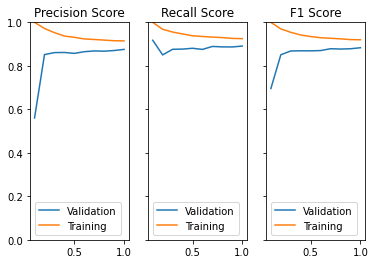

In [ ]:
plot_curves(list_sample_size, list_precision_val, list_precision_train, list_recall_val, list_recall_train, list_f1_val, list_f1_train)

### TF-IDF Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
parameters = {'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}

tfidf_vectorizer = TfidfVectorizer(min_df=0.005)
tfidf_train = tfidf_vectorizer.fit_transform(X_train.array)
tfidf_val = tfidf_vectorizer.transform(X_val.array)

log_reg = LogisticRegression(max_iter=2000)
classifier = GridSearchCV(log_reg, parameters, scoring=['accuracy', 'recall_micro', 'precision_micro', 'f1_micro'], refit='accuracy')
classifier.fit(tfidf_train, y_train)
prediction = classifier.predict(tfidf_val)

print('Best solver for LogisticRegression classification with TfidfVectorizer vectorization:')
print(classifier.best_params_)
print('Classification report:')
print(classification_report(y_val, prediction))

Best solver for LogisticRegression classification with TfidfVectorizer vectorization:
{'solver': 'newton-cg'}
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      3366
           1       0.88      0.90      0.89      3386

    accuracy                           0.89      6752
   macro avg       0.89      0.89      0.89      6752
weighted avg       0.89      0.89      0.89      6752



In [ ]:
parameters = {'penalty': ['l2', 'none'],
              'solver': ['newton-cg'],
              'C': [0.1, 1, 10]}

tfidf_vectorizer = TfidfVectorizer(min_df=0.005)
tfidf_train = tfidf_vectorizer.fit_transform(X_train.array)
tfidf_val = tfidf_vectorizer.transform(X_val.array)

log_reg = LogisticRegression(max_iter=2000)
classifier = GridSearchCV(log_reg, parameters, scoring=['accuracy', 'recall_micro', 'precision_micro', 'f1_micro'], refit='accuracy')
classifier.fit(tfidf_train, y_train)
prediction = classifier.predict(tfidf_val)

print('Best hyperparameters for LogisticRegression classification with TfidfVectorizer vectorization')
print(classifier.best_params_)
print('Classification report')
print(classification_report(y_val, prediction))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

Best hyperparameters for LogisticRegression classification with TfidfVectorizer vectorization
{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Classification report
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      3366
           1       0.88      0.90      0.89      3386

    accuracy                           0.89      6752
   macro avg       0.89      0.89      0.89      6752
weighted avg       0.89      0.89      0.89      6752



In [ ]:
list_precision_train = []
list_precision_val = []

list_recall_train = []
list_recall_val = []

list_f1_train = []
list_f1_val = []

list_sample_size = []

for times in range(10):

  X, _, y, _ = train_test_split(X_train, y_train, test_size=(1 - (times * 0.1 + 0.001)))

  tfidf_vectorizer = TfidfVectorizer(min_df=0.005)
  tfidf_train = tfidf_vectorizer.fit_transform(X.array)
  tfidf_val = tfidf_vectorizer.transform(X_val.array)

  classifier = LogisticRegression(penalty='l2', C=1, solver='newton-cg', max_iter=2000)
  classifier.fit(tfidf_train, y)

  results_train = classifier.predict(tfidf_train)
  results_val = classifier.predict(tfidf_val)

  print('===== test_size=' + '{:.3f}'.format(1 - (times * 0.1 + 0.001)) + ' =====', sep='')

  precision_train = precision_score(y, results_train)
  precision_val = precision_score(y_val, results_val)

  print('Precision score Train:\t\t' + '{:.3f}'.format(precision_train))
  print('Precision score Validation:\t' + '{:.3f}'.format(precision_val))

  recall_train = recall_score(y, results_train)
  recall_val = recall_score(y_val, results_val)

  print('Recall score Train:\t\t' + '{:.3f}'.format(recall_train))
  print('Recall score Validation:\t' + '{:.3f}'.format(recall_val))

  f1_train = f1_score(y, results_train)
  f1_val = f1_score(y_val, results_val)

  print('F1 score Train:\t\t\t' + '{:.3f}'.format(f1_train))
  print('F1 score Validation:\t\t' + '{:.3f}'.format(f1_val) + '\n')

  list_precision_train.append(precision_train)
  list_precision_val.append(precision_val)
  list_recall_train.append(recall_train)
  list_recall_val.append(recall_val)
  list_f1_train.append(f1_train)
  list_f1_val.append(f1_val)
  list_sample_size.append((times * 0.1 + 0.1))

===== test_size=0.999 =====
Precision score Train:		1.000
Precision score Validation:	0.516
Recall score Train:		1.000
Recall score Validation:	0.975
F1 score Train:			1.000
F1 score Validation:		0.675

===== test_size=0.899 =====
Precision score Train:		0.923
Precision score Validation:	0.848
Recall score Train:		0.941
Recall score Validation:	0.884
F1 score Train:			0.932
F1 score Validation:		0.866

===== test_size=0.799 =====
Precision score Train:		0.908
Precision score Validation:	0.862
Recall score Train:		0.937
Recall score Validation:	0.889
F1 score Train:			0.923
F1 score Validation:		0.875

===== test_size=0.699 =====
Precision score Train:		0.907
Precision score Validation:	0.879
Recall score Train:		0.920
Recall score Validation:	0.881
F1 score Train:			0.914
F1 score Validation:		0.880

===== test_size=0.599 =====
Precision score Train:		0.906
Precision score Validation:	0.875
Recall score Train:		0.932
Recall score Validation:	0.898
F1 score Train:			0.919
F1 score Valid

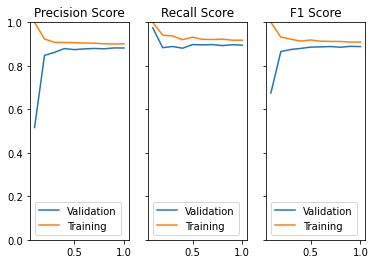

In [ ]:
plot_curves(list_sample_size, list_precision_val, list_precision_train, list_recall_val, list_recall_train, list_f1_val, list_f1_train)

### Hashing Vectorizer

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

In [ ]:
parameters = {'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}

hash_vectorizer = TfidfVectorizer(min_df=0.005)
hash_train = hash_vectorizer.fit_transform(X_train.array)
hash_val = hash_vectorizer.transform(X_val.array)

log_reg = LogisticRegression(max_iter=2000)
classifier = GridSearchCV(log_reg, parameters, scoring=['accuracy', 'recall_micro', 'precision_micro', 'f1_micro'], refit='accuracy')
classifier.fit(hash_train, y_train)
prediction = classifier.predict(hash_val)

print('Best solver for LogisticRegression classification with HashingVectorizer vectorization:')
print(classifier.best_params_)
print('Classification report:')
print(classification_report(y_val, prediction))

Best solver for LogisticRegression classification with HashingVectorizer vectorization:
{'solver': 'newton-cg'}
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      3366
           1       0.88      0.90      0.89      3386

    accuracy                           0.89      6752
   macro avg       0.89      0.89      0.89      6752
weighted avg       0.89      0.89      0.89      6752



In [ ]:
parameters = {'penalty': ['l2', 'none'],
              'solver': ['newton-cg'],
              'C': [0.1, 1, 10]}

hash_vectorizer = HashingVectorizer(n_features=2**12)
hash_train = hash_vectorizer.fit_transform(X_train.array)
hash_val = hash_vectorizer.transform(X_val.array)

log_reg = LogisticRegression(max_iter=2000)
classifier = GridSearchCV(log_reg, parameters, scoring=['accuracy', 'recall_micro', 'precision_micro', 'f1_micro'], refit='accuracy')
classifier.fit(hash_train, y_train)
prediction = classifier.predict(hash_val)

print('Best hyperparameters for LogisticRegression classification with TfidfVectorizer vectorization')
print(classifier.best_params_)
print('Classification report')
print(classification_report(y_val, prediction))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

Best hyperparameters for LogisticRegression classification with TfidfVectorizer vectorization
{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Classification report
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3366
           1       0.85      0.87      0.86      3386

    accuracy                           0.86      6752
   macro avg       0.86      0.86      0.86      6752
weighted avg       0.86      0.86      0.86      6752



In [ ]:
list_precision_train = []
list_precision_val = []

list_recall_train = []
list_recall_val = []

list_f1_train = []
list_f1_val = []

list_sample_size = []

for times in range(10):

  X, _, y, _ = train_test_split(X_train, y_train, test_size=(1 - (times * 0.1 + 0.001)))

  hash_vectorizer = HashingVectorizer(n_features=2**12)
  hash_train = hash_vectorizer.fit_transform(X.array)
  hash_val = hash_vectorizer.transform(X_val.array)

  classifier = LogisticRegression(penalty='l2', C=1, solver='newton-cg', max_iter=2000)
  classifier.fit(hash_train, y)

  results_train = classifier.predict(hash_train)
  results_val = classifier.predict(hash_val)

  print('===== test_size=' + '{:.3f}'.format(1 - (times * 0.1 + 0.001)) + ' =====', sep='')

  precision_train = precision_score(y, results_train)
  precision_val = precision_score(y_val, results_val)

  print('Precision score Train:\t\t' + '{:.3f}'.format(precision_train))
  print('Precision score Validation:\t' + '{:.3f}'.format(precision_val))

  recall_train = recall_score(y, results_train)
  recall_val = recall_score(y_val, results_val)

  print('Recall score Train:\t\t' + '{:.3f}'.format(recall_train))
  print('Recall score Validation:\t' + '{:.3f}'.format(recall_val))

  f1_train = f1_score(y, results_train)
  f1_val = f1_score(y_val, results_val)

  print('F1 score Train:\t\t\t' + '{:.3f}'.format(f1_train))
  print('F1 score Validation:\t\t' + '{:.3f}'.format(f1_val) + '\n')

  list_precision_train.append(precision_train)
  list_precision_val.append(precision_val)
  list_recall_train.append(recall_train)
  list_recall_val.append(recall_val)
  list_f1_train.append(f1_train)
  list_f1_val.append(f1_val)
  list_sample_size.append((times * 0.1 + 0.1))

===== test_size=0.999 =====
Precision score Train:		1.000
Precision score Validation:	0.509
Recall score Train:		1.000
Recall score Validation:	0.996
F1 score Train:			1.000
F1 score Validation:		0.673

===== test_size=0.899 =====
Precision score Train:		0.893
Precision score Validation:	0.820
Recall score Train:		0.918
Recall score Validation:	0.856
F1 score Train:			0.905
F1 score Validation:		0.838

===== test_size=0.799 =====
Precision score Train:		0.880
Precision score Validation:	0.828
Recall score Train:		0.901
Recall score Validation:	0.848
F1 score Train:			0.891
F1 score Validation:		0.838

===== test_size=0.699 =====
Precision score Train:		0.887
Precision score Validation:	0.838
Recall score Train:		0.900
Recall score Validation:	0.859
F1 score Train:			0.893
F1 score Validation:		0.848

===== test_size=0.599 =====
Precision score Train:		0.881
Precision score Validation:	0.842
Recall score Train:		0.896
Recall score Validation:	0.864
F1 score Train:			0.888
F1 score Valid

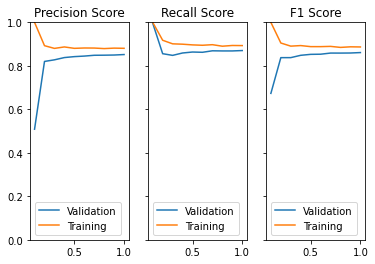

In [ ]:
plot_curves(list_sample_size, list_precision_val, list_precision_train, list_recall_val, list_recall_train, list_f1_val, list_f1_train)

## Best Model

TF-IDF Vectorization and Logistic Regression with L2 Regularization and 'newton-cg' solver with 'c'=1

In [ ]:
list_precision_train = []
list_precision_val = []

list_recall_train = []
list_recall_val = []

list_f1_train = []
list_f1_val = []

list_sample_size = []

for times in range(10):

  X, _, y, _ = train_test_split(X_train, y_train, test_size=(1 - (times * 0.1 + 0.001)))

  tfidf_vectorizer = TfidfVectorizer(min_df=0.005)
  tfidf_train = tfidf_vectorizer.fit_transform(X.array)
  tfidf_val = tfidf_vectorizer.transform(X_val.array)

  classifier = LogisticRegression(penalty='l2', C=1, solver='newton-cg', max_iter=2000)
  classifier.fit(tfidf_train, y)

  results_train = classifier.predict(tfidf_train)
  results_val = classifier.predict(tfidf_val)

  print('===== test_size=' + '{:.3f}'.format(1 - (times * 0.1 + 0.001)) + ' =====', sep='')

  precision_train = precision_score(y, results_train)
  precision_val = precision_score(y_val, results_val)

  print('Precision score Train:\t\t' + '{:.3f}'.format(precision_train))
  print('Precision score Validation:\t' + '{:.3f}'.format(precision_val))

  recall_train = recall_score(y, results_train)
  recall_val = recall_score(y_val, results_val)

  print('Recall score Train:\t\t' + '{:.3f}'.format(recall_train))
  print('Recall score Validation:\t' + '{:.3f}'.format(recall_val))

  f1_train = f1_score(y, results_train)
  f1_val = f1_score(y_val, results_val)

  print('F1 score Train:\t\t\t' + '{:.3f}'.format(f1_train))
  print('F1 score Validation:\t\t' + '{:.3f}'.format(f1_val) + '\n')

  list_precision_train.append(precision_train)
  list_precision_val.append(precision_val)
  list_recall_train.append(recall_train)
  list_recall_val.append(recall_val)
  list_f1_train.append(f1_train)
  list_f1_val.append(f1_val)
  list_sample_size.append((times * 0.1 + 0.1))

===== test_size=0.999 =====
Precision score Train:		1.000
Precision score Validation:	0.572
Recall score Train:		1.000
Recall score Validation:	0.959
F1 score Train:			1.000
F1 score Validation:		0.716

===== test_size=0.899 =====
Precision score Train:		0.924
Precision score Validation:	0.838
Recall score Train:		0.946
Recall score Validation:	0.892
F1 score Train:			0.935
F1 score Validation:		0.864

===== test_size=0.799 =====
Precision score Train:		0.916
Precision score Validation:	0.856
Recall score Train:		0.932
Recall score Validation:	0.890
F1 score Train:			0.924
F1 score Validation:		0.872

===== test_size=0.699 =====
Precision score Train:		0.909
Precision score Validation:	0.860
Recall score Train:		0.929
Recall score Validation:	0.890
F1 score Train:			0.919
F1 score Validation:		0.875

===== test_size=0.599 =====
Precision score Train:		0.906
Precision score Validation:	0.865
Recall score Train:		0.918
Recall score Validation:	0.884
F1 score Train:			0.912
F1 score Valid

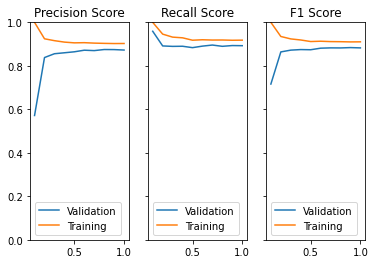

In [ ]:
plot_curves(list_sample_size, list_precision_val, list_precision_train, list_recall_val, list_recall_train, list_f1_val, list_f1_train)